In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import glob

In [3]:
#sys.path.append("/srv01/technion/hagaik/repo/KMDHierarchicalClustering/")

In [4]:
import KMDHierarchicalClustering
from KMDHierarchicalClustering import cluster_scoring
from FlowCytometryTools import FCMeasurement
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, pairwise_distances
import pandas as pd

# Wide-range half-moons

In [4]:
moons_wide = np.load("toy_ds/moons_wide/sil_scores_wide_moons_noisy_seed5.npz")

In [14]:
moons_wide['k_range']

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

['Z', 'acc', 'nmi', 'ari', 'kmdsil', 'k_range', 'mcs', 'kmdsil_norm', 'acc_corr', 'nmi_corr', 'ari_corr']


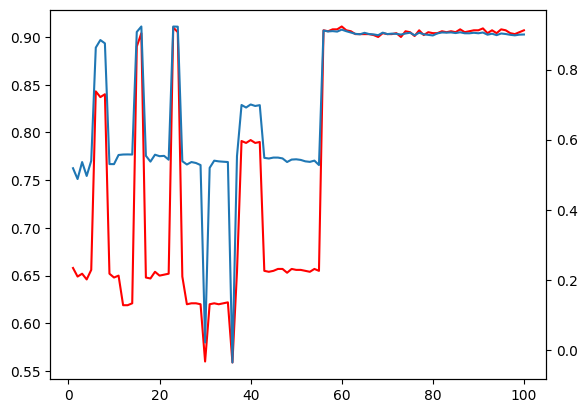

In [18]:
print(list(moons_wide.keys()))
plt.plot(moons_wide['k_range'][::1], moons_wide['acc'][::1], c='red')
ax2 = plt.gca().twinx()
ax2.plot(moons_wide['k_range'][::1], moons_wide['kmdsil_norm'][::1])

In [19]:
wide_moons_data = np.load("toy_ds/moons_wide/data_moons_noisy_seed5.npz")

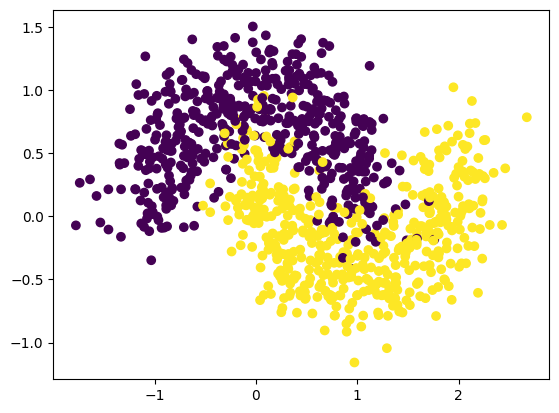

In [23]:
plt.scatter(*wide_moons_data['X'].T, c=wide_moons_data['y'])

# Flow cytometry

In [18]:
data_name = 'Levine_32dim'
datafile = r'flow/raw_data/'+ data_name+ '.fcs'
sample = FCMeasurement(ID='Test Sample', datafile=datafile)
df = sample.data
mask = ~df['label'].isna()
df = df[mask]
print(mask.shape)
df.shape

(265627,)


/Local/md_kaplan/anaconda3/envs/kmd/lib/python3.9/site-packages/fcsparser/api.py:474: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


(104184, 41)

In [19]:
import pathlib
def get_y(seed):
    np.random.seed(seed)
    fit_filename = f"flow/results/{data_name}_sample20000_seed{seed}_best.npz" # Found using get_best.py
    fit = np.load(fit_filename)
    idx = np.load(f"flow/preprocessed/{data_name}_sample20000_seed{seed}.npz")['sampled_cells']
    y_pred = fit['y_pred']
    y_true = fit['y_true']
    
    return y_true, y_pred, df.iloc[idx]

In [20]:
score = []
count = []
for s in [1,2,3,4,5]:
    y_true, y_pred, _ = get_y(s)
    print(f"{s=} num of y_preds={len(y_pred)}")
    mask = np.isfinite(y_true)
    count.append(mask.sum())
    y_true = y_true[mask]
    score.append(cluster_scoring.hungarian_acc(y_true, y_pred[mask])[0] )
print(score)
print(np.mean(score), np.mean(count)), count

Pattern: flow/results/Levine_32dim_sample20000_seed1_best.npz
1.0
s=1 num of y_preds=20000
Pattern: flow/results/Levine_32dim_sample20000_seed2_best.npz
1.0
s=2 num of y_preds=20000
Pattern: flow/results/Levine_32dim_sample20000_seed3_best.npz
1.0
s=3 num of y_preds=20000
Pattern: flow/results/Levine_32dim_sample20000_seed4_best.npz
1.0
s=4 num of y_preds=20000
Pattern: flow/results/Levine_32dim_sample20000_seed5_best.npz
1.0
s=5 num of y_preds=20000
[0.947, 0.9497, 0.95205, 0.945, 0.94975]
0.9487 20000.0


(None, [20000, 20000, 20000, 20000, 20000])

In [21]:
s = 3 # Choose the seed that has the highest score
y_true, y_pred, X = get_y(s)
print(f"{s=} num of y_preds={len(y_pred)}")
mask = np.isfinite(y_true)
# Remove technical columns like viability, file number, label, etc
#X = X.iloc[mask] # Levine_13dim
X = X.iloc[mask][X.columns[2:-5]] # Levine_32dim
#X = X.iloc[mask][X.columns[8:-7]] # Samusik_01
y_true = y_true[mask].astype(int)
y_pred = y_pred[mask]
dists = KMDHierarchicalClustering.KMDClustering.calc_dists({}, X, 'correlation')

Pattern: flow/results/Levine_32dim_sample20000_seed3_best.npz
1.0
s=3 num of y_preds=20000
1.0


In [22]:
fit = np.load(f"flow/results/{data_name}_sample20000_seed{s}_best.npz")
y_pred2, *_ = KMDHierarchicalClustering.predict_clust_label.predict_from_Z(fit['Z'],
                                                                           14, #number of clusters
                                                                           50, # minimum cluster size
                                                                           dists, fit['k'])

/Local/md_kaplan/anaconda3/envs/kmd/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [25]:
(y_pred2 == y_pred).mean()

0.9923

In [ ]:
plt.rcParams['figure.dpi'] = 300
np.random.seed(1)
cluster_scoring.tsne_presentation(dists, y_true, y_pred2)

# Large dataset section

## Levine15_32

In [8]:
data_file = r"flow/raw_data/Levine_32dim.fcs"
df = FCMeasurement(ID='Test Sample', datafile=data_file).data

/Local/md_kaplan/anaconda3/envs/current/lib/python3.9/site-packages/fcsparser/api.py:440: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


In [9]:
num = 2
np.random.seed(num)
idx = []
i = 0
while i < 5000:
    idx_new = np.random.randint(int(df.shape[0]), size=(1,))
    if np.isnan(df['label'][idx_new].to_numpy()):
        continue
    else:
        idx.append(int(idx_new[0]))
        i += 1
idx = np.array(idx)

In [12]:
X = df.to_numpy()[idx][:, 2:-5] # Levine_32dim
dists = KMDHierarchicalClustering.KMDClustering.calc_dists({}, X, 'correlation')
y_true_sub = df['label'][idx].astype(int).to_numpy()
y_pred_sub = np.load("sampling/Levine_32dim_y_pred_n_5000_seed2_k40.npy")

In [ ]:
plt.rcParams['figure.dpi'] = 600
cluster_scoring.tsne_presentation(dists, y_true_sub, y_pred_sub)

## PBMC68K_Pure

In [65]:
data_file = "sampling/pbmc_pure/pure6_pca.csv"
df = pd.read_csv(data_file)
X = df.filter(like='PC').to_numpy()
y_true = df['label'].to_numpy()

In [66]:
pred_file = "sampling/pbmc_pure/pure6_kmd_seed1_sample5000_mcs50_n6.npz"
pred = np.load(pred_file)
y_pred = pred['y_pred']
idx = pred['idx_sub']

In [67]:
y_pred_sub = y_pred[idx]
y_true_sub = y_true[idx]
X_sub = X[idx]

In [68]:
_, y = cluster_scoring.hungarian_acc(y_true_sub, y_pred_sub)

In [71]:
dists = KMDHierarchicalClustering.KMDClustering.calc_dists({}, X_sub, 'correlation')

In [ ]:
plt.rcParams['figure.dpi'] = 600
cluster_scoring.tsne_presentation(dists, y_true_sub, y_pred_sub)

## Simulated 1M

In [6]:
X = np.load('sampling/1Msim/1Msim/1M_pca.npy')
y_true = np.load('sampling/1Msim/1Msim/1M_y_true.npy', allow_pickle=True).astype(int)
y_pred = np.load("sampling/1Msim/1Msim/1M_y_pred.npy")
idx = np.load("sampling/1Msim/1Msim/1M_idx_sampled.npy")

In [8]:
X = np.load('sampling/1Msim/1Msim.seed0/1M_pca.npy')
y_true = np.load('sampling/1Msim/1Msim.seed0/1M_y_true.npy', allow_pickle=True).astype(int)
#y_pred = np.load("sampling/1Msim/1Msim.seed0/1M_y_pred.npy")
np.random.seed(1)
idx = np.random.randint(X.shape[0], size=5000)

In [9]:
#y_pred_sub = y_pred[idx]
y_true_sub = y_true[idx]
X_sub = X[idx]

In [10]:
dists = KMDHierarchicalClustering.KMDClustering.calc_dists({}, X_sub, 'correlation')

In [12]:
y_true_sub

array([6, 6, 8, ..., 8, 5, 6])

In [ ]:
plt.rcParams['figure.dpi'] = 100
#cluster_scoring.tsne_presentation(dists, y_true_sub, y_pred_sub)
cluster_scoring.tsne_presentation(dists, y_true_sub, y_true_sub - 1)

In [ ]:
plt.rcParams['figure.dpi'] = 100
cluster_scoring.tsne_presentation(dists, y_true_sub, y_pred_sub)

In [11]:
adjusted_rand_score(y_true, y_pred)

0.881949059673354